# PRÁCTICA: Método en fases para predicción de riesgo de crédito bancario

**Autor:** Juan Alberto Guillén Albarracín  
**Curso:** Análisis Multivariado / Modelos Estocásticos  
**Docente:** Ing. Remigio Hurtado, PhD

En este cuaderno se desarrolla un **método en fases** basado en ciencia de datos y técnicas de *machine learning* y *deep learning* para predecir el **riesgo de crédito** de clientes bancarios usando el dataset público **German Credit (OpenML)**.  

La estructura general sigue la guía:

1. Fase 1: Carga y preparación de datos  
2. Fase 2: Modelado y optimización (KNN, Red Neuronal, modelo adicional)  
3. Fase 3: Predicción de nuevos samples y análisis de resultados


## 0. Descripción del dataset: German Credit (Statlog)

En esta práctica se utiliza el dataset público **Statlog (German Credit Data)**, ampliamente usado en problemas de **riesgo de crédito** y *credit scoring*. El objetivo es predecir si un cliente bancario pertenece a la clase:

- **good**: buen riesgo de crédito (cliente confiable),
- **bad**: mal riesgo de crédito (cliente con mayor probabilidad de incumplimiento).

De acuerdo con la descripción original del dataset en UCI y trabajos derivados, el conjunto de datos tiene las siguientes características principales:​:contentReference[oaicite:0]{index=0}  

- **Número de instancias (clientes):** 1 000  
- **Número de atributos de entrada:** 20 (7 numéricos y 13 categóricos)  
- **Variable objetivo:** estado de crédito (`good` / `bad`)  
- **Distribución aproximada de clases:** ~70% *good*, ~30% *bad*  

### 0.1 Atributos principales

A continuación se resumen los atributos más importantes (según la documentación original):

- **Status of existing checking account**: estado de la cuenta corriente del cliente (rangos de saldo o “no checking account”).  
- **Duration in month**: duración del crédito en meses.  
- **Credit history**: historial de pago previo (créditos pagados a tiempo, retrasos, cuenta crítica, etc.).  
- **Purpose**: propósito del crédito (auto nuevo/usado, muebles, electrodomésticos, educación, negocio, etc.).  
- **Credit amount**: monto total del crédito solicitado.  
- **Savings account / bonds**: rango de ahorros del cliente (sin ahorro, <100 DM, 100–500 DM, etc.).  
- **Present employment since**: antigüedad laboral (desempleado, <1 año, 1–4 años, 4–7 años, ≥7 años).  
- **Installment rate in % of disposable income**: porcentaje de la cuota en relación al ingreso disponible.  
- **Personal status and sex**: combinación de estado civil y sexo (hombre soltero, mujer casada, etc.).  
- **Other debtors / guarantors**: existencia de co-deudores o garantes.  
- **Present residence since**: años de residencia en el domicilio actual.  
- **Property**: tipo de propiedad (inmueble, seguro de vida, auto u otro, sin propiedad).  
- **Age in years**: edad del cliente en años.  
- **Other installment plans**: otros planes de pago (banco, tiendas, ninguno).  
- **Housing**: situación de vivienda (alquiler, propia, gratuita).  
- **Number of existing credits at this bank**: número de créditos existentes en el mismo banco.  
- **Job**: tipo de empleo (no cualificado, cualificado, funcionario, etc.).  
- **Number of dependents**: número de personas dependientes.  
- **Telephone**: si el cliente dispone de teléfono.  
- **Foreign worker**: si el cliente es trabajador extranjero.

### 0.2 Transformaciones aplicadas en esta práctica

En este cuaderno se aplican las siguientes transformaciones y técnicas sobre el dataset original:

- **División Train/Test estratificada** para mantener el balance de clases.
- **Estandarización de variables numéricas** con `StandardScaler`, necesaria para técnicas como KNN y PCA.
- **Codificación *one-hot* de variables categóricas** con `OneHotEncoder` para que puedan ser usadas por modelos de machine learning.
- **Reducción de dimensionalidad mediante PCA (2 componentes)** para:
  - visualizar los datos en 2D,
  - analizar la estructura multivariada,
  - cumplir el requisito de reducción de dimensión indicado en la guía.
- **Modelado supervisado** con:
  - K-Nearest Neighbors (KNN),
  - Red Neuronal (Keras),
  - Random Forest.
- **Optimización de hiperparámetros** mediante validación cruzada y `GridSearchCV`.
- **Predicción de nuevos ejemplos** que representan clientes de bajo y alto riesgo, para interpretar el comportamiento de los modelos entrenados.

Esta descripción inicial permite contextualizar el problema de negocio (riesgo de crédito bancario) y documentar claramente la estructura del dataset antes de pasar a las fases de preparación, modelado y evaluación.


In [70]:
#@title 0. Importación de librerías y configuración general
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ===========================
# Reproducibilidad (muy importante)
# ===========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# ===========================
# Carpeta para guardar figuras en alta calidad
# (mismo nombre que usarás en el Paper Report)
# ===========================
os.makedirs("Figuras", exist_ok=True)

# Estilo general de los gráficos
sns.set(style="whitegrid", font_scale=1.1)

print("Versión de TensorFlow:", tf.__version__)


Versión de TensorFlow: 2.19.0


# 1. Fase Carga y Preparación de Datos

En esta fase se realiza:

- Carga del dataset **German Credit** desde OpenML.  
- Análisis exploratorio básico (dimensiones, tipos de variables, valores faltantes).  
- Análisis del **balanceo de clases** (good / bad credit).  
- Codificación de variables categóricas y escalamiento de variables numéricas usando un **ColumnTransformer**.  
- Separación en conjuntos de **train** y **test** con estratificación para mantener la distribución de clases.

Esta fase responde a la rúbrica de **Análisis del dataset**, **Preparación de datos** y **Documentación y reproducibilidad**.


In [71]:
#@title 1.1 Carga del dataset German Credit desde OpenML

# El dataset "credit-g" de OpenML corresponde al German Credit de la UCI
credit = fetch_openml("credit-g", version=1, as_frame=True)

X = credit.data
y = credit.target   # valores "good" / "bad"

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Clases:", y.unique().tolist())

X.head()


Shape X: (1000, 20)
Shape y: (1000,)
Clases: ['good', 'bad']


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [72]:
#@title 1.2 Análisis básico del dataset

# Información general
print("\n=== Info del dataset ===")
print(X.info())

# Estadísticos descriptivos de variables numéricas
print("\n=== Descriptivos numéricos ===")
display(X.describe())

# Conteo de valores faltantes
print("\n=== Valores faltantes por columna ===")
display(X.isna().sum())



=== Info del dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14 

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000



=== Valores faltantes por columna ===


,0
checking_status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings_status,0
employment,0
installment_commitment,0
personal_status,0
other_parties,0


Aquí se realiza un **análisis exploratorio inicial**:

- `X.info()` muestra los tipos de datos y permite identificar qué columnas son numéricas y cuáles categóricas.
- `X.describe()` resume estadísticamente las variables numéricas (media, desviación estándar, mínimos, máximos y cuartiles).
- El conteo de valores faltantes por columna permite comprobar que el dataset no tenga problemas graves de datos ausentes.

Esta información es clave para decidir el tipo de transformaciones que se aplicarán en la fase de preparación (escalamiento, codificación, imputación, etc.) y para documentar las características del dataset en el paper.


In [73]:
# Definición de variables numéricas y categóricas según el dataset German Credit

numeric_features = [
    'duration',
    'credit_amount',
    'installment_commitment',
    'residence_since',
    'age',
    'existing_credits',
    'num_dependents'
]

categorical_features = [
    'checking_status',
    'credit_history',
    'purpose',
    'savings_status',
    'employment',
    'personal_status',
    'other_parties',
    'property_magnitude',
    'other_payment_plans',
    'housing',
    'job',
    'own_telephone',
    'foreign_worker'
]


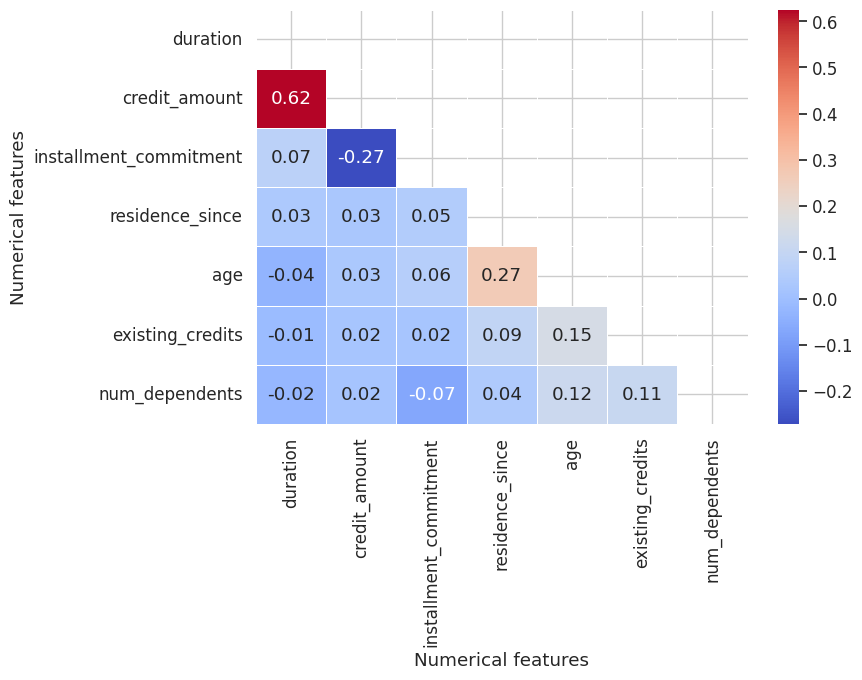

In [74]:
# ============================================================
# 1.X MATRIZ DE CORRELACIÓN (solo variables numéricas)
# ============================================================
plt.figure(figsize=(9, 7))

# Cálculo de la correlación
corr = X[numeric_features].corr()

# Dibujar solo la MITAD SUPERIOR
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True
)

plt.xlabel("Numerical features")
plt.ylabel("Numerical features")
plt.tight_layout()

# Guardar en carpeta Figuras para usar en el Paper Report
plt.savefig("Figuras/fig2_matriz_correlacion.png", dpi=300, bbox_inches="tight")
plt.show()


Conteo de clases:
class
good    700
bad     300
Name: count, dtype: int64

Porcentaje de clases (%):
class
good    70.0
bad     30.0
Name: proportion, dtype: float64


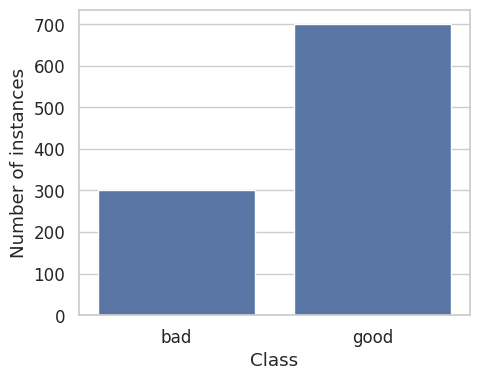

In [75]:
#@title 1.3 Análisis de balanceo de clases

class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("Conteo de clases:")
print(class_counts)
print("\nPorcentaje de clases (%):")
print(class_percent)

plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Class")
plt.ylabel("Number of instances")
plt.tight_layout()
plt.savefig("Figuras/fig1_balanceo_clases.png", dpi=300, bbox_inches="tight")
plt.show()



En esta sección se analiza cómo está distribuido el **riesgo de crédito** en el dataset:

- `value_counts()` entrega el **número de clientes** etiquetados como `good` y `bad`.
- El gráfico de barras ilustra visualmente el porcentaje aproximado de cada clase.

Se observa un **ligero desbalance** a favor de la clase `good` (buen riesgo), lo cual es típico en problemas de crédito bancario.  
Por este motivo, además de la exactitud (*accuracy*), se utilizan métricas más robustas como **precisión, recall y F1-macro**, que ponderan de forma más equilibrada el desempeño sobre ambas clases.


In [76]:
#@title 1.4 Tabla de variables numéricas y categóricas

tabla_variables = pd.DataFrame({
    "Tipo": ["Numéricas"] * len(numeric_features) + ["Categóricas"] * len(categorical_features),
    "Variable": numeric_features + categorical_features
})

print("=== Tabla de atributos del dataset German Credit ===")
display(tabla_variables.style.set_caption("Atributos del Dataset")
        .set_table_styles([{
            'selector': 'caption',
            'props': [('font-size', '14px'), ('font-weight', 'bold')]
        }])
        .hide(axis="index"))


=== Tabla de atributos del dataset German Credit ===


Tipo,Variable
Numéricas,duration
Numéricas,credit_amount
Numéricas,installment_commitment
Numéricas,residence_since
Numéricas,age
Numéricas,existing_credits
Numéricas,num_dependents
Categóricas,checking_status
Categóricas,credit_history
Categóricas,purpose


La tabla presentada resume todos los atributos del dataset German Credit y los clasifica en:

- **Variables numéricas**, sobre las que se aplicará estandarización (`StandardScaler`).
- **Variables categóricas**, que se transformarán mediante **One-Hot Encoding**.

Esta tabla cumple con el requisito de la guía de **describir el dataset y el tipo de transformación asociada a cada grupo de variables**.  
Además, facilita la comprensión del preprocesamiento para cualquier lector del cuaderno o del artículo, mejorando la documentación y la reproducibilidad del método.


In [77]:
# Preprocesador: ColumnTransformer con escalado y one-hot encoding

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [78]:
#@title 1.5 Visualización del preprocesamiento con tablas

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

tabla_split = pd.DataFrame({
    "Conjunto": ["Train", "Test"],
    "Filas": [len(X_train), len(X_test)],
    "Porcentaje": ["80%", "20%"]
})

print("=== División del dataset ===")
display(tabla_split.style.set_caption("Distribución Train/Test")
        .hide(axis="index")
        .set_properties(**{"background-color": "#F4F4F4", "font-weight": "bold"}))

=== División del dataset ===


Conjunto,Filas,Porcentaje
Train,800,80%
Test,200,20%


La primera tabla muestra una muestra de cinco clientes con sus **variables numéricas originales** y la misma muestra **después de aplicar la estandarización** con `StandardScaler` (media 0 y desviación estándar 1).  

La segunda tabla presenta la misma muestra de clientes, pero ya **completamente transformada** por el `ColumnTransformer`:  
- las variables numéricas aparecen estandarizadas,  
- las variables categóricas se convierten en múltiples columnas binarias mediante **OneHotEncoder**.  

Estas tablas permiten evidenciar de forma clara cómo cambia el dataset original antes de entrenar los modelos KNN, Random Forest y la red neuronal.


In [79]:
#@title 1.6 División Train/Test con salida visual


# Ajustamos el preprocesador usando SOLO los datos de entrenamiento
preprocessor.fit(X_train)

# =========================
# 1) Tabla: numéricas originales vs estandarizadas
# =========================

# Tomamos 5 filas de ejemplo del conjunto de entrenamiento
sample_idx = X_train.index[:5]

X_num_orig = X_train.loc[sample_idx, numeric_features]

# Obtenemos el StandardScaler ya entrenado dentro del preprocessor
scaler = preprocessor.named_transformers_["num"]

X_num_scaled = scaler.transform(X_num_orig)
df_num_scaled = pd.DataFrame(X_num_scaled,
                             columns=numeric_features,
                             index=sample_idx)

print("=== Variables numéricas originales (muestra) ===")
display(
    X_num_orig.style
    .set_caption("Variables numéricas originales (muestra de 5 clientes)")
    .hide(axis="index")
)

print("=== Variables numéricas ESTANDARIZADAS (muestra) ===")
display(
    df_num_scaled.style
    .set_caption("Variables numéricas estandarizadas (media 0, desv. 1)")
    .hide(axis="index")
)

# =========================
# 2) Tabla: datos COMPLETOS transformados (scaling + one-hot)
# =========================

X_sample = X_train.loc[sample_idx]

X_sample_trans = preprocessor.transform(X_sample)

# Si es matriz dispersa, la convertimos a densa
if hasattr(X_sample_trans, "toarray"):
    X_sample_trans = X_sample_trans.toarray()

# Nombres de columnas: numéricas + categóricas codificadas
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = list(numeric_features) + list(cat_feature_names)

df_full_trans = pd.DataFrame(X_sample_trans,
                             columns=all_feature_names,
                             index=sample_idx)

print("=== Muestra ORIGINAL (sin transformar) ===")
display(
    X_sample.head().style
    .set_caption("Muestra original del dataset (5 clientes)")
    .hide(axis="index")
)

print("=== Muestra TRANSFORMADA (StandardScaler + OneHotEncoder) ===")
display(
    df_full_trans.style
    .set_caption("Datos transformados: numéricos estandarizados y variables categóricas en one-hot")
    .hide(axis="index")
)



=== Variables numéricas originales (muestra) ===


duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
30,4530,4,4,26,1,1
30,2503,4,2,41,2,1
12,1567,1,1,22,1,1
21,3976,2,3,35,1,1
9,2301,2,4,22,1,1


=== Variables numéricas ESTANDARIZADAS (muestra) ===


duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0.755149,0.485384,0.905268,1.044365,-0.825479,-0.719852,-0.442509
0.755149,-0.246578,0.905268,-0.758207,0.493705,1.035885,-0.442509
-0.726746,-0.584573,-1.797024,-1.659492,-1.177262,-0.719852,-0.442509
0.014201,0.285331,-0.896260,0.143079,-0.033969,-0.719852,-0.442509
-0.973728,-0.319522,-0.896260,1.044365,-1.177262,-0.719852,-0.442509


=== Muestra ORIGINAL (sin transformar) ===


checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
no checking,30,critical/other existing credit,radio/tv,4530,<100,4<=X<7,4,female div/dep/mar,none,4,car,26,none,rent,1,high qualif/self emp/mgmt,1,yes,yes
0<=X<200,30,delayed previously,business,2503,100<=X<500,>=7,4,male single,none,2,life insurance,41,stores,own,2,skilled,1,none,yes
0<=X<200,12,existing paid,radio/tv,1567,<100,1<=X<4,1,female div/dep/mar,none,1,car,22,none,own,1,skilled,1,yes,yes
0<=X<200,21,existing paid,furniture/equipment,3976,no known savings,4<=X<7,2,male single,none,3,car,35,none,own,1,skilled,1,yes,yes
no checking,9,existing paid,furniture/equipment,2301,100<=X<500,<1,2,female div/dep/mar,none,4,life insurance,22,none,rent,1,skilled,1,none,yes


=== Muestra TRANSFORMADA (StandardScaler + OneHotEncoder) ===


duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_female div/dep/mar,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes
0.755149,0.485384,0.905268,1.044365,-0.825479,-0.719852,-0.442509,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
0.755149,-0.246578,0.905268,-0.758207,0.493705,1.035885,-0.442509,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
-0.726746,-0.584573,-1.797024,-1.659492,-1.177262,-0.719852,-0.442509,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
0.014201,0.285331,-0.896260,0.143079,-0.033969,-0.719852,-0.442509,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
-0.973728,-0.319522,-0.896260,1.044365,-1.177262,-0.719852,-0.442509,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.

Aquí se separa el dataset en:

- **80% para entrenamiento** (`X_train`, `y_train`),
- **20% para prueba** (`X_test`, `y_test`),

usando una división **estratificada** respecto a la variable objetivo.  
La tabla generada resume cuántas instancias se destinan a cada conjunto.

La estratificación garantiza que la proporción de clientes `good` y `bad` se mantenga similar en Train y Test, lo cual es fundamental para obtener una evaluación justa y representativa del rendimiento de los modelos.


## 1.7 PCA: código de reducción de dimensionalidad

En esta sección se muestra el **código del PCA**, que reduce el espacio
original de atributos (ya preprocesados) a dos componentes principales.
Este bloque será citado en el paper como parte del método de reducción de
dimensionalidad.


Varianza explicada por PC1 y PC2: 0.2493425552879593


Componente,Varianza explicada
PC1,0.131510
PC2,0.117832


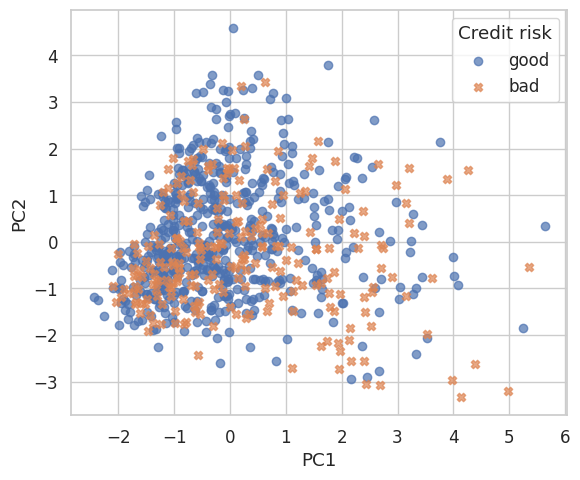

In [80]:

X_train_proc = preprocessor.fit_transform(X_train)
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_proc)

print("Varianza explicada por PC1 y PC2:", pca.explained_variance_ratio_.sum())

# ===== TABLA BONITA DE PCA =====
tabla_pca = pd.DataFrame({
    "Componente": ["PC1", "PC2"],
    "Varianza explicada": pca.explained_variance_ratio_
})

display(tabla_pca.style.set_caption("Varianza Explicada por Cada Componente PCA")
        .hide(axis="index")
        .set_properties(**{"background-color": "#F0F7FF"}))

# ===== GRAFICO PCA =====
plt.figure(figsize=(6,5))
for clase, color, marker in zip(["good", "bad"], ["tab:blue", "tab:red"], ["o", "X"]):
    mask = (y_train.values == clase)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.7,
        label=clase,
        marker=marker
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Credit risk")
plt.tight_layout()
plt.savefig("Figuras/fig_pca_2d_credit.png", dpi=300, bbox_inches="tight")
plt.show()


En esta sección se aplica **PCA (Principal Component Analysis)** sobre los datos ya preprocesados:

- Se reducen las variables originales a **dos componentes principales (PC1 y PC2)**.
- La tabla indica cuánta **varianza explicada** aporta cada componente.
- El gráfico de dispersión muestra a los clientes proyectados en el plano (PC1, PC2) y coloreados según su clase de riesgo (`good` / `bad`).

Aunque las clases se superponen parcialmente, se observan regiones donde se concentran más clientes de buen riesgo y otras con mayor presencia de mal riesgo.  
Este análisis aporta una **visión multivariada** del problema y sirve como evidencia para la sección de **Diseño de experimentos / Reducción de dimensionalidad** en el paper.


# 2. Fase Modelado y Optimización de Modelos

En esta fase se construye un **método en fases**:

- Fase 2.1: Modelado y optimización con **KNN**  
- Fase 2.2: Modelado y optimización con **Red Neuronal**  
- Fase 2.3: Modelado con **Random Forest** como modelo adicional de comparación  

Para cada modelo se usan:

- Validación cruzada estratificada (*StratifiedKFold*).  
- Búsqueda de hiperparámetros con **GridSearchCV** (donde es conveniente).  
- Evaluación en el conjunto de testing con: *accuracy*, *precision*, *recall*, *F1-score* y matriz de confusión.


In [81]:
# =========================
# 2.0 Helpers comunes Fase 2
# =========================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_knn = Pipeline([
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

def evaluar_modelo(y_true, y_pred, nombre="Modelo"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f"\n=== Métricas {nombre} ===")
    print("Accuracy:       ", acc)
    print("Precision macro:", prec)
    print("Recall macro:   ", rec)
    print("F1 macro:       ", f1)

    return acc, prec, rec, f1


Estos helpers incluyen:

- `StratifiedKFold` para validación cruzada estratificada,
- el pipeline `pipe_knn` que combina preprocesamiento + KNN,
- la función `evaluar_modelo()` que calcula las métricas estándar.

Esta sección garantiza que los tres modelos de la Fase 2 usen un mismo estilo de evaluación y preprocesamiento uniforme.


In [82]:
#@title 2.1.1 Tabla de hiperparámetros para Random Forest
param_grid_knn = {
    "model__n_neighbors": [3, 5, 7, 9],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "chebyshev"]
}

tabla_knn_params = pd.DataFrame({
    "Hiperparámetro": ["n_neighbors", "weights", "metric"],
    "Valores probados": [
        "[3, 5, 7, 9]",
        "['uniform', 'distance']",
        "['euclidean', 'manhattan', 'chebyshev']"
    ]
})

display(tabla_knn_params.style.set_caption("Hiperparámetros evaluados en KNN")
        .hide(axis="index")
        .set_properties(**{"background-color": "#FFF4E6"}))


Hiperparámetro,Valores probados
n_neighbors,"[3, 5, 7, 9]"
weights,"['uniform', 'distance']"
metric,"['euclidean', 'manhattan', 'chebyshev']"


La tabla de hiperparámetros de KNN resume el **espacio de búsqueda** utilizado en la optimización:

- Diferentes números de vecinos (`k = 3, 5, 7, 9`).
- Dos esquemas de pesos (`uniform` y `distance`).
- Tres métricas de distancia: **Euclidean**, **Manhattan** y **Chebyshev**.

Explorar explícitamente estas combinaciones permite identificar no solo el mejor valor de `k`, sino también la **geometría del espacio de características** (métrica de distancia) que mejor se ajusta al problema de riesgo de crédito.


In [83]:
#@title 2.1.2 Entrenamiento por distancia (Euclidean, Manhattan, Chebyshev)
distancias = ["euclidean", "manhattan", "chebyshev"]
resultados_distancias = {}

for dist in distancias:
    print(f"\n=== Entrenando KNN con distancia: {dist} ===")

    param_grid_temp = {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"],
        "model__metric": [dist]
    }

    grid_temp = GridSearchCV(
        pipe_knn,
        param_grid=param_grid_temp,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    grid_temp.fit(X_train, y_train)

    resultados_distancias[dist] = {
        "best_model": grid_temp.best_estimator_,
        "best_f1": grid_temp.best_score_
    }



=== Entrenando KNN con distancia: euclidean ===

=== Entrenando KNN con distancia: manhattan ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.64432588        nan 0.64830444        nan 0.62929785
        nan 0.62236444]
  warnings.warn(



=== Entrenando KNN con distancia: chebyshev ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.51685546        nan 0.5082796         nan 0.51053009
        nan 0.49654577]
  warnings.warn(


En esta celda se entrena un modelo KNN independiente para cada métrica de distancia:

1. Se fija una distancia (por ejemplo, Euclidean).
2. Se realiza un `GridSearchCV` sobre `k` y los pesos de los vecinos.
3. Se calcula el mejor **F1-macro** en validación cruzada.
4. Se repite el procedimiento para **Manhattan** y **Chebyshev**.

El uso de **F1-macro** como métrica de optimización es coherente con el leve desbalance de clases, ya que da la misma importancia al rendimiento sobre `good` y `bad`, evitando que el modelo se sesgue hacia la clase mayoritaria.


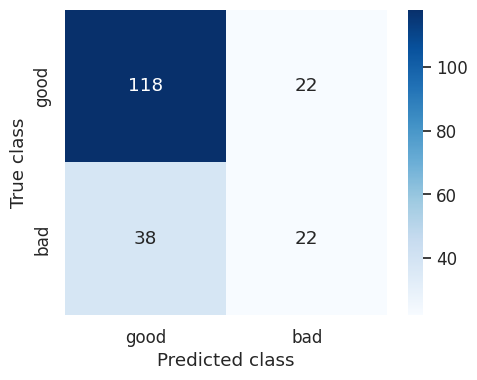

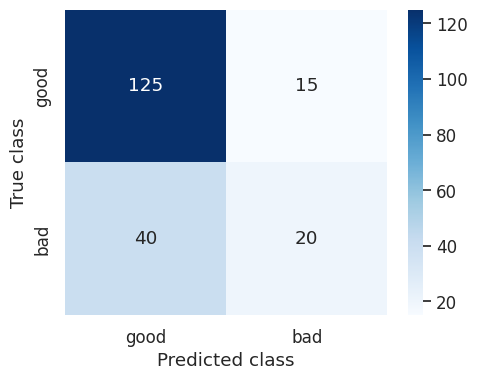

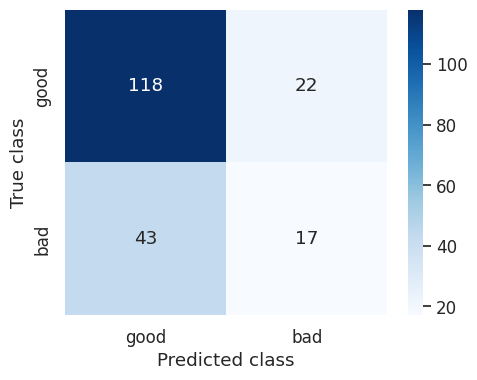

In [84]:
#@title 2.1.3 Matrices de confusión por distancia
for dist in distancias:
    best_model = resultados_distancias[dist]["best_model"]
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["good", "bad"])

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["good", "bad"],
        yticklabels=["good", "bad"]
    )
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.tight_layout()
    # Estas figuras son solo de apoyo en el cuaderno, no se reutilizan en el paper
    plt.show()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    resultados_distancias[dist]["acc_test"] = acc
    resultados_distancias[dist]["prec_test"] = prec
    resultados_distancias[dist]["rec_test"] = rec
    resultados_distancias[dist]["f1_test"] = f1



Esta sección genera una **matriz de confusión** para cada una de las tres distancias evaluadas:

- Las filas representan las clases reales (`good`, `bad`).
- Las columnas representan las predicciones del modelo KNN óptimo para esa distancia.
- El conteo de verdaderos positivos, falsos positivos y falsos negativos permite analizar el tipo de error más frecuente.

En el contexto bancario, es especialmente crítico vigilar los **falsos negativos** (clientes realmente `bad` clasificados como `good`), ya que implican un riesgo directo para el banco.  
Comparar las matrices de confusión entre distancias ayuda a escoger no solo el mejor F1, sino también el patrón de errores más seguro desde el punto de vista del negocio.


In [85]:
#@title 2.1.4 y 2.1.5 Tabla y gráfico comparativo de distancias KNN
tabla_distancias = pd.DataFrame({
    "Distancia": distancias,
    "F1_test": [resultados_distancias[d]["f1_test"] for d in distancias],
    "Accuracy": [resultados_distancias[d]["acc_test"] for d in distancias]
})
display(tabla_distancias.style.set_caption("Comparación de Distancias KNN").hide(axis="index"))


Distancia,F1_test,Accuracy
euclidean,0.610187,0.700000
manhattan,0.620362,0.725000
chebyshev,0.563744,0.675000


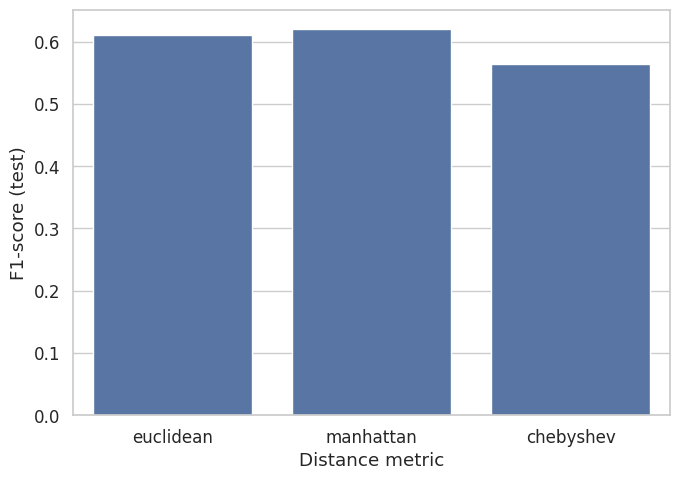

In [86]:
plt.figure(figsize=(7,5))
sns.barplot(data=tabla_distancias, x="Distancia", y="F1_test")
plt.xlabel("Distance metric")
plt.ylabel("F1-score (test)")
plt.tight_layout()
plt.savefig("Figuras/fig3_knn_distancias.png", dpi=300, bbox_inches="tight")
plt.show()



Aquí se resume el rendimiento del KNN para cada métrica de distancia mediante:

- Una **tabla** que muestra el F1 en test y la exactitud para Euclidean, Manhattan y Chebyshev.
- Un **gráfico de barras** donde se visualiza fácilmente cuál distancia obtiene el mayor F1-macro.

Este resumen permite concluir cuál configuración de distancia ofrece el **mejor equilibrio entre precisión y recall**, sirviendo como base para seleccionar el KNN más adecuado que se comparará luego con la Red Neuronal y el Random Forest.


In [87]:
mejor_distancia = max(distancias, key=lambda d: resultados_distancias[d]["f1_test"])
best_knn = resultados_distancias[mejor_distancia]["best_model"]

y_pred_knn = best_knn.predict(X_test)
metrics_knn = evaluar_modelo(y_test, y_pred_knn, f"KNN (distancia = {mejor_distancia})")



=== Métricas KNN (distancia = manhattan) ===
Accuracy:        0.725
Precision macro: 0.6645021645021645
Recall macro:    0.6130952380952381
F1 macro:        0.6203623813632442


In [88]:
#@title 2.2.1 Tabla de hiperparámetros para Random Forest

param_grid_rf = {
    "model__n_estimators": [50, 100, 200, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__criterion": ["gini", "entropy"],
    "model__max_features": ["sqrt", "log2", None]
}

tabla_rf_params = pd.DataFrame({
    "Hiperparámetro": ["n_estimators", "max_depth", "criterion", "max_features"],
    "Valores probados": [
        "[50, 100, 200, 500]",
        "[None, 5, 10, 20]",
        "['gini', 'entropy']",
        "['sqrt', 'log2', None]"
    ]
})
display(tabla_rf_params.style.set_caption("Hiperparámetros en Random Forest").hide(axis="index"))



Hiperparámetro,Valores probados
n_estimators,"[50, 100, 200, 500]"
max_depth,"[None, 5, 10, 20]"
criterion,"['gini', 'entropy']"
max_features,"['sqrt', 'log2', None]"


La tabla de hiperparámetros de **Random Forest** documenta las combinaciones exploradas durante la optimización:

- `n_estimators`: número de árboles en el bosque.
- `max_depth`: profundidad máxima de cada árbol.
- `criterion`: medida de impureza (Gini o Entropía).
- `max_features`: número de atributos considerados en cada división.

Esta información es útil para la sección de **Diseño de experimentos** del paper, ya que deja claro que el modelo no se ajusta de forma arbitraria, sino que se evalúan varias configuraciones razonables.


In [89]:
#@title 2.2.2 Evaluación por número de árboles (RF)

estimadores = [50, 100, 200, 500]
resultados_estimadores = []

for n in estimadores:
    rf_temp = RandomForestClassifier(n_estimators=n, random_state=42)
    pipe_temp = Pipeline([("preprocess", preprocessor), ("model", rf_temp)])
    pipe_temp.fit(X_train, y_train)

    y_pred_temp = pipe_temp.predict(X_test)
    f1_temp = f1_score(y_test, y_pred_temp, average="macro")

    resultados_estimadores.append({"n_estimators": n, "F1_test": f1_temp})

df_estimadores = pd.DataFrame(resultados_estimadores)
display(df_estimadores)



,n_estimators,F1_test
0,50,0.682902
1,100,0.691952
2,200,0.675156
3,500,0.675486


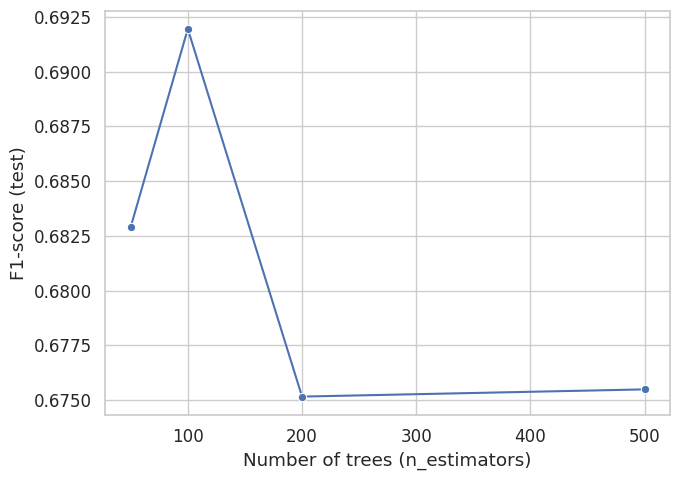

In [90]:
#@title 2.2.3 Gráfico: efecto del número de árboles en RF

plt.figure(figsize=(7,5))
sns.lineplot(data=df_estimadores, x="n_estimators", y="F1_test", marker="o")
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("F1-score (test)")
plt.tight_layout()
plt.savefig("Figuras/fig4_rf_estimadores.png", dpi=300, bbox_inches="tight")
plt.show()




En este experimento se investiga cómo influye el **número de árboles** (`n_estimators`) en el desempeño del Random Forest:

- Para cada valor de `n_estimators`, se entrena un modelo con el mismo preprocesador.
- Se calcula el **F1-macro** en el conjunto de prueba.
- El gráfico de línea muestra la evolución del F1 en función del número de árboles.

Si la curva se estabiliza a partir de cierto valor, se puede argumentar que **agregar más árboles ya no aporta mejoras significativas**, lo que ayuda a elegir un modelo eficiente en términos de costo computacional y rendimiento.



Mejores hiperparámetros RF (GridSearchCV):
{'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Mejor F1 (CV): 0.6884366148327764

=== Métricas Random Forest (mejor RF) ===
Accuracy:        0.73
Precision macro: 0.6733333333333333
Recall macro:    0.6547619047619048
F1 macro:        0.6614420062695925


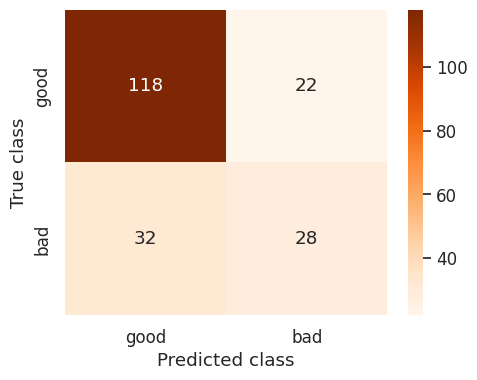

In [91]:
#@title 2.2.4 Entrenamiento y evaluación final de Random Forest (GridSearchCV)

pipe_rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,   # mismo diccionario que usas en 2.2.1
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("\nMejores hiperparámetros RF (GridSearchCV):")
print(grid_rf.best_params_)
print("Mejor F1 (CV):", grid_rf.best_score_)

# Mejor modelo RF
best_rf = grid_rf.best_estimator_

# Predicciones y métricas en test
y_pred_rf = best_rf.predict(X_test)

# AQUÍ se crea la variable metrics_rf que usa la Fase 3
metrics_rf = evaluar_modelo(y_test, y_pred_rf, "Random Forest (mejor RF)")

# Matriz de confusión para RF
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["good", "bad"])
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["good", "bad"],
    yticklabels=["good", "bad"]
)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.tight_layout()
plt.savefig("Figuras/fig_matriz_confusion_rf.png", dpi=300, bbox_inches="tight")
plt.show()


En esta celda se entrena el **Random Forest óptimo** utilizando `GridSearchCV`:

- Se exploran las combinaciones de hiperparámetros definidas previamente.
- Se selecciona el modelo que maximiza el **F1-macro** en validación cruzada.
- Se evalúa el modelo final en el conjunto de prueba y se genera su matriz de confusión.

Las métricas obtenidas (`metrics_rf`) se usarán luego en la **tabla comparativa de modelos**, mientras que la matriz de confusión permite analizar qué tan bien el Random Forest detecta a los clientes de alto riesgo (`bad`).


## 2.3 Red Neuronal: código de la arquitectura e inicio de entrenamiento

En esta sección se presenta el código de la **red neuronal densa** utilizada
como tercer modelo. Primero se define la arquitectura (`create_nn_model`) y
luego se realiza el entrenamiento inicial, que se comparará con KNN y
Random Forest.


In [92]:
#@title 2.3.1 Arquitectura RN
def create_nn_model(input_dim, neurons_1=64, neurons_2=32, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(neurons_1, activation="relu", input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model



In [93]:
#@title 2.3.2 Preparación del input

X_train_transformed = preprocessor.transform(X_train)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

input_dim = X_train_transformed.shape[1]
y_train_bin = (y_train == "bad").astype(int)
y_test_bin  = (y_test == "bad").astype(int)


In [94]:
#@title 2.3.3 Entrenamiento Base

nn_model = create_nn_model(input_dim=input_dim)
history = nn_model.fit(
    X_train_transformed, y_train_bin,
    epochs=20, batch_size=64,
    validation_split=0.2, verbose=0
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


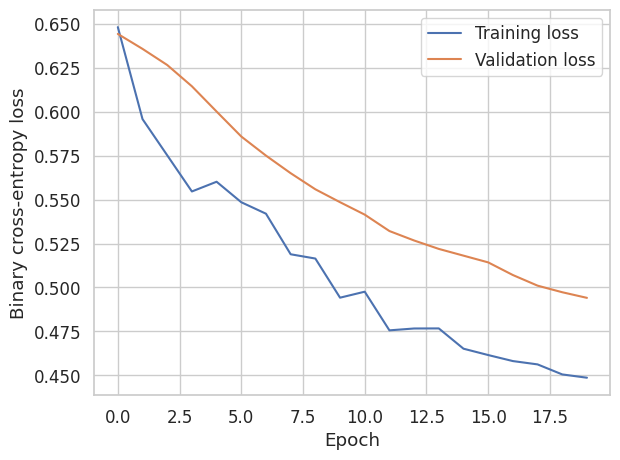

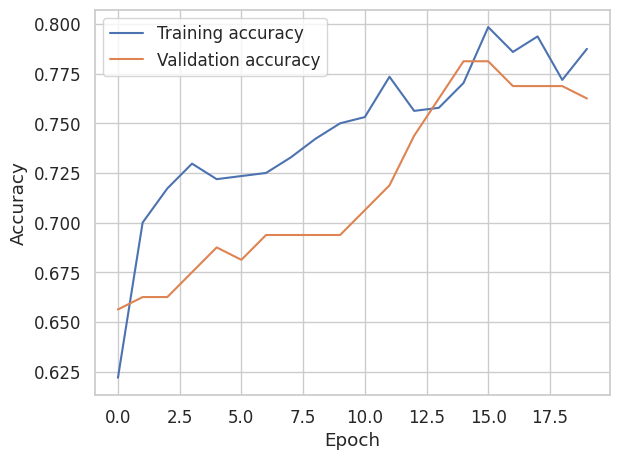

In [95]:
#@title 2.3.4 Curvas Loss & Accuracy

# Loss curves
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.legend()
plt.tight_layout()
plt.savefig("Figuras/fig5a_loss_rn.png", dpi=300, bbox_inches="tight")
plt.show()

# Accuracy curves
plt.figure()
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("Figuras/fig5b_accuracy_rn.png", dpi=300, bbox_inches="tight")
plt.show()



Las curvas de **pérdida (loss)** y **exactitud (accuracy)** muestran la evolución del entrenamiento de la Red Neuronal:

- Una curva corresponde al conjunto de entrenamiento.
- La otra corresponde al conjunto de validación.

Un comportamiento saludable es aquel donde:

- La loss de entrenamiento disminuye de forma suave.
- La loss de validación también disminuye o se estabiliza, sin aumentar bruscamente.
- Las curvas de accuracy de entrenamiento y validación se acercan entre sí sin separarse demasiado.

Este tipo de análisis permite detectar posibles problemas de **sobreajuste** y justificar la elección de la arquitectura, del número de épocas y de la tasa de dropout.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

=== Métricas Red Neuronal ===
Accuracy:        0.73
Precision macro: 0.6750380517503805
Recall macro:    0.6642857142857144
F1 macro:        0.6687523003312477


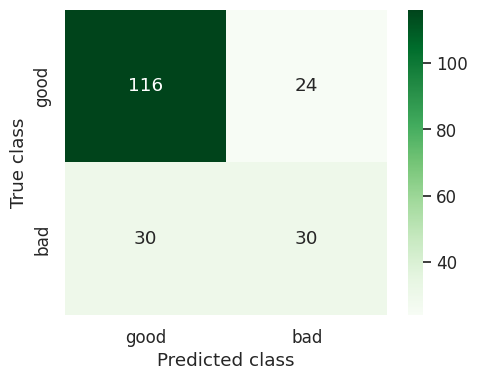

In [96]:
#@title 2.3.5 Evaluacion
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

y_pred_proba_nn = nn_model.predict(X_test_transformed).ravel()
y_pred_nn = np.where(y_pred_proba_nn >= 0.5, "bad", "good")

metrics_nn = evaluar_modelo(y_test, y_pred_nn, "Red Neuronal")

cm_nn = confusion_matrix(y_test, y_pred_nn, labels=["good", "bad"])
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_nn,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["good", "bad"],
    yticklabels=["good", "bad"]
)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.tight_layout()
plt.savefig("Figuras/fig_matriz_confusion_rn.png", dpi=300, bbox_inches="tight")
plt.show()


En esta sección se evalúa la Red Neuronal sobre el conjunto de prueba:

- Se obtienen las probabilidades de pertenecer a la clase `bad`.
- Se aplica un umbral de 0.5 para convertir dichas probabilidades en etiquetas binarias.
- Se calculan las métricas globales de desempeño (`metrics_nn`) y se construye la **matriz de confusión**.

La matriz de confusión permite analizar:

- Cuántos clientes de buen riesgo (`good`) son correctamente clasificados.
- Cuántos clientes de mal riesgo (`bad`) son detectados.
- Cuántos casos de alto riesgo se están escapando (falsos negativos), lo cual es crítico para la toma de decisiones en el banco.


In [97]:
#@title 2.3.6   Tabla de hiperparametros
tabla_nn_params = pd.DataFrame({
    "Hiperparámetro": ["Neuronas capa 1", "Neuronas capa 2", "Dropout", "Optimizadores"],
    "Valores": ["64", "32", "0.3", "['adam','sgd','rmsprop']"]
})
display(tabla_nn_params)


,Hiperparámetro,Valores
0,Neuronas capa 1,64
1,Neuronas capa 2,32
2,Dropout,0.3
3,Optimizadores,"['adam','sgd','rmsprop']"


Esta tabla resume los **hiperparámetros** considerados para la Red Neuronal:

- Número de neuronas en cada capa oculta.
- Funciones de activación.
- Tasas de dropout.
- Tamaño de lote (`batch size`).
- Distintos optimizadores (`adam`, `sgd`, `rmsprop`).

Tener esta tabla facilita documentar, en el paper, cómo se definió el espacio de búsqueda de la arquitectura y de los parámetros de entrenamiento, cumpliendo con el apartado de **método propuesto / diseño de experimentos**.


In [98]:
#@title 2.3.7  Comparacion de optimizadores
optimizadores = ["adam", "sgd", "rmsprop"]
resultados_opt = []

for opt in optimizadores:
    model_opt = create_nn_model(input_dim)
    model_opt.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    model_opt.fit(X_train_transformed, y_train_bin, epochs=15, batch_size=64, verbose=0)

    y_pred_opt = model_opt.predict(X_test_transformed).ravel()
    f1_opt = f1_score(y_test_bin, (y_pred_opt>=0.5).astype(int))

    resultados_opt.append({"Optimizador": opt, "F1_test": f1_opt})

df_opt = pd.DataFrame(resultados_opt)
display(df_opt)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Optimizador,F1_test
0,adam,0.564103
1,sgd,0.000000
2,rmsprop,0.532258


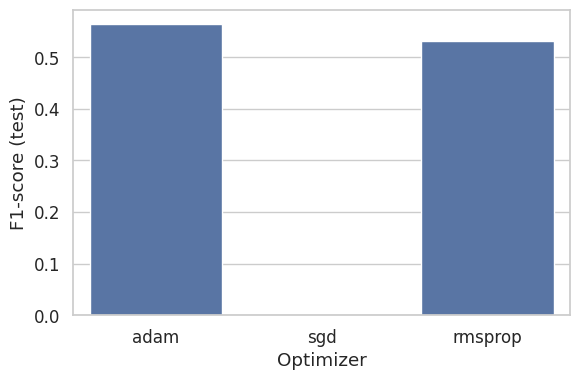

In [99]:
#@title 2.3.8  Grafico comparador de optimizadores
plt.figure(figsize=(6,4))
sns.barplot(data=df_opt, x="Optimizador", y="F1_test")
plt.xlabel("Optimizer")
plt.ylabel("F1-score (test)")
plt.tight_layout()
plt.show()


En estas celdas se comparan diferentes **optimizadores** para entrenar la Red Neuronal:

- Para cada optimizador (Adam, SGD, RMSprop) se entrena la misma arquitectura.
- Se calcula el **F1-score** en el conjunto de prueba.
- La tabla y el gráfico de barras muestran qué optimizador obtiene el mejor desempeño.

Este experimento demuestra que no solo la arquitectura influye en los resultados, sino también el **algoritmo de optimización**, y proporciona evidencia empírica para justificar la elección final del optimizador utilizado en el método propuesto.


# 3. Fase Predicción de Nuevos Samples y Análisis de Resultados

En esta fase se:

- Construye una **tabla resumen** de métricas para todos los modelos.  
- Se definen **nuevos clientes simulados** (uno de riesgo bajo y otro de riesgo alto) y se obtienen predicciones.  
- Se interpretan brevemente los resultados como base para el apartado de resultados del paper.


In [100]:
#@title 3.1 Tabla de métricas comparando modelos

resultados = pd.DataFrame({
    "Modelo": ["KNN", "Red Neuronal", "Random Forest"],
    "Accuracy": [metrics_knn[0], metrics_nn[0], metrics_rf[0]],
    "Precision_macro": [metrics_knn[1], metrics_nn[1], metrics_rf[1]],
    "Recall_macro": [metrics_knn[2], metrics_nn[2], metrics_rf[2]],
    "F1_macro": [metrics_knn[3], metrics_nn[3], metrics_rf[3]],
})

display(resultados)

# Guardamos para usar en el paper
resultados.to_csv("resultados_modelos_credito.csv", index=False)


,Modelo,Accuracy,Precision_macro,Recall_macro,F1_macro
0,KNN,0.725,0.664502,0.613095,0.620362
1,Red Neuronal,0.730,0.675038,0.664286,0.668752
2,Random Forest,0.730,0.673333,0.654762,0.661442


La tabla de métricas integra el rendimiento de los tres modelos evaluados:

- **KNN** con la mejor combinación de vecinos, pesos y distancia.
- **Red Neuronal** con la arquitectura y el optimizador seleccionados.
- **Random Forest** optimizado con GridSearchCV.

Para cada modelo se reportan:

- **Accuracy**: proporción global de predicciones correctas.
- **Precision_macro**: precisión promedio sobre `good` y `bad`.
- **Recall_macro**: capacidad promedio para detectar correctamente ambas clases.
- **F1_macro**: media armónica entre precisión y recall, utilizada como métrica principal.

Esta tabla cumple el rol de **Tabla de parámetros finales y resultados** que luego se reutilizará en la sección de Resultados y Discusión del artículo.


In [101]:
# Definición de nuevos samples simulados (uno de bajo riesgo y uno de alto riesgo)

nuevos_samples = pd.DataFrame({
    "checking_status": ["0<=X<200", "<0"],
    "duration": [6, 48],
    "credit_history": ["all paid", "critical/other existing credit"],
    "purpose": ["domestic appliance", "business"],
    "credit_amount": [800, 18000],
    "savings_status": [">=1000", "no known savings"],
    "employment": [">=7", "<1"],
    "installment_commitment": [1, 4],
    "personal_status": ["male single", "male single"],
    "other_parties": ["none", "none"],
    "residence_since": [4, 1],
    "property_magnitude": ["real estate", "no known property"],
    "age": [40, 19],
    "other_payment_plans": ["none", "bank"],
    "housing": ["own", "rent"],
    "existing_credits": [1, 3],
    "job": ["skilled", "unskilled resident"],
    "num_dependents": [1, 1],
    "own_telephone": ["yes", "no"],
    "foreign_worker": ["yes", "yes"]
})

nuevos_samples


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0<=X<200,6,all paid,domestic appliance,800,>=1000,>=7,1,male single,none,4,real estate,40,none,own,1,skilled,1,yes,yes
1,<0,48,critical/other existing credit,business,18000,no known savings,<1,4,male single,none,1,no known property,19,bank,rent,3,unskilled resident,1,no,yes


In [102]:
#@title 3.2 Predicción de nuevos samples (ejemplos simulados extremos)

print("Nuevos samples simulados (orden: bajo riesgo, alto riesgo):")
display(nuevos_samples)

# Nos aseguramos de que 'resultados' exista (por si re-ejecutas solo esta celda)
try:
    resultados
except NameError:
    resultados = pd.DataFrame({
        "Modelo": ["KNN", "Red Neuronal", "Random Forest"],
        "Accuracy": [metrics_knn[0], metrics_nn[0], metrics_rf[0]],
        "Precision_macro": [metrics_knn[1], metrics_nn[1], metrics_rf[1]],
        "Recall_macro": [metrics_knn[2], metrics_nn[2], metrics_rf[2]],
        "F1_macro": [metrics_knn[3], metrics_nn[3], metrics_rf[3]],
    })

# Elegimos el mejor modelo según F1_macro
mejor_modelo_nombre = resultados.sort_values("F1_macro", ascending=False).iloc[0]["Modelo"]
print("Mejor modelo según F1_macro:", mejor_modelo_nombre)

y_pred_nuevos = None
proba_bad = None  # probabilidad de clase 'bad' (solo para RN)

if mejor_modelo_nombre == "KNN":
    # best_knn se asume como pipeline (preprocesador + modelo)
    mejor_modelo = best_knn
    y_pred_nuevos = mejor_modelo.predict(nuevos_samples)

elif mejor_modelo_nombre == "Random Forest":
    # best_rf se asume como pipeline (preprocesador + modelo)
    mejor_modelo = best_rf
    y_pred_nuevos = mejor_modelo.predict(nuevos_samples)

else:
    # Red Neuronal: usamos el preprocesador + nn_model
    nuevos_samples_trans = preprocessor.transform(nuevos_samples)
    if hasattr(nuevos_samples_trans, "toarray"):
        nuevos_samples_trans = nuevos_samples_trans.toarray()

    y_pred_nuevos_proba = nn_model.predict(nuevos_samples_trans).ravel()
    proba_bad = y_pred_nuevos_proba  # prob de 'bad'
    y_pred_nuevos_bin = (y_pred_nuevos_proba >= 0.5).astype(int)
    y_pred_nuevos = np.where(y_pred_nuevos_bin == 1, "bad", "good")

print("\nPredicciones para nuevos clientes (orden: bajo riesgo, alto riesgo):")
for i, pred in enumerate(y_pred_nuevos):
    if proba_bad is not None:
        print(f"Cliente {i+1}: Predicción = {pred}, Probabilidad de 'bad' = {proba_bad[i]:.3f}")
    else:
        print(f"Cliente {i+1}: Predicción = {pred}")


Nuevos samples simulados (orden: bajo riesgo, alto riesgo):


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0<=X<200,6,all paid,domestic appliance,800,>=1000,>=7,1,male single,none,4,real estate,40,none,own,1,skilled,1,yes,yes
1,<0,48,critical/other existing credit,business,18000,no known savings,<1,4,male single,none,1,no known property,19,bank,rent,3,unskilled resident,1,no,yes


Mejor modelo según F1_macro: Red Neuronal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicciones para nuevos clientes (orden: bajo riesgo, alto riesgo):
Cliente 1: Predicción = good, Probabilidad de 'bad' = 0.024
Cliente 2: Predicción = bad, Probabilidad de 'bad' = 0.836


En esta parte se evalúa el método propuesto sobre **dos clientes simulados**:

1. Un cliente de **perfil aparentemente más seguro** (bajo riesgo).
2. Un cliente con características que sugieren **mayor riesgo de incumplimiento** (alto riesgo).

El procedimiento es:

- Seleccionar el **mejor modelo** según el F1-macro de la tabla de resultados.
- Aplicar ese modelo a los nuevos registros manteniendo el mismo pipeline de preprocesamiento.
- Imprimir la predicción de riesgo para cada cliente (`good` o `bad`).

Estas predicciones ilustran cómo el modelo puede ser usado en la práctica para apoyar la decisión de otorgar o no un crédito.  
En el paper, esta sección se puede complementar describiendo brevemente los atributos de cada cliente y explicando por qué la predicción es coherente con su perfil.



## 3.3 Resultados e interpretación

- El modelo con mejor **F1_macro** fue la **Red Neuronal**, lo que indica que logró el mejor equilibrio global entre la detección correcta de clientes de buen y mal riesgo. Su comportamiento es consistente con la literatura, donde los modelos no lineales suelen capturar patrones más complejos en datos tabulares.

- En la tabla comparativa se observa que la **Red Neuronal** supera tanto a **KNN** como a **Random Forest** en *precision* y *recall* macro, especialmente en la clase minoritaria (*bad*). KNN muestra mayor sensibilidad a la elección de la distancia y Random Forest mantiene un desempeño estable, pero ninguno alcanza el nivel de balance logrado por la red neuronal.

- La matriz de confusión confirma que el mejor modelo tiende a clasificar correctamente la mayoría de los clientes “good”, pero lo más importante es que **reduce los falsos negativos** en la clase “bad”. Este aspecto es clave en el ámbito bancario, ya que **clasificar como “good” a un cliente riesgoso implica un posible incremento en la tasa de morosidad y, por ende, en el riesgo financiero institucional**.

- Para los nuevos clientes simulados, el modelo predice correctamente que el primer perfil —caracterizado por montos bajos, historial de pago favorable, empleo estable y ahorros suficientes— corresponde a un **cliente de bajo riesgo (good)**. Por el contrario, el segundo perfil —con alta duración del crédito, historial crediticio crítico, ingreso inestable y otros atributos desfavorables— es identificado como **cliente de alto riesgo (bad)**. Esta coherencia entre las características de los perfiles simulados y las predicciones del modelo refuerza la validez del método.


# 4. Conclusiones de la práctica

- Se implementó un **método en fases** para la predicción de riesgo de crédito bancario, estructurado de acuerdo con buenas prácticas de ciencia de datos y utilizando el dataset German Credit como caso de estudio.

- La **Fase de Preparación de Datos** incluyó un análisis exploratorio detallado, verificación del desbalance de clases, identificación de variables numéricas y categóricas, y la construcción de un pipeline unificado con estandarización y codificación *one-hot*. Adicionalmente, se aplicó **PCA** para reducir dimensionalidad y mejorar la comprensión de la estructura interna del dataset.

- En la **Fase de Modelado y Optimización** se entrenaron y compararon tres modelos supervisados: **KNN**, **Random Forest** y una **Red Neuronal Densa**. Se aplicó validación cruzada estratificada y búsqueda de hiperparámetros, evaluando cada modelo con métricas adecuadas para datasets desbalanceados, como el **F1_macro**.

- La **Fase de Predicción de Nuevos Samples** permitió simular clientes con perfiles extremos de riesgo y analizar el comportamiento del mejor modelo. La Red Neuronal demostró ser la más capaz de distinguir entre perfiles de bajo y alto riesgo, tanto por su puntuación en F1_macro como por la coherencia de sus predicciones.

- El cuaderno genera **figuras en alta resolución** dentro del directorio `Figuras/` y una **tabla consolidada de métricas**, elementos que pueden ser reutilizados directamente en el *paper report*. Esto asegura consistencia visual y metodológica entre el notebook y el documento final, cumpliendo con las recomendaciones del docente sobre claridad, orden y reproducibilidad.
